In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# URL to Titanic CSV (raw file)
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Select useful columns
data = df[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]].copy()

# Handle missing values
data["Age"] = data["Age"].fillna(data["Age"].median())
data["Fare"] = data["Fare"].fillna(data["Fare"].median())

# Encode categorical
data["Sex"] = data["Sex"].map({"male": 1, "female": 0})

# Split features/labels
X = data.drop("Survived", axis=1).values
y = data["Survived"].values

# Add bias term (column of 1s)
X_bias = np.c_[np.ones(X.shape[0]), X]

# Feature scaling (standardization)
X_mean, X_std = X_bias[:, 1:].mean(axis=0), X_bias[:, 1:].std(axis=0)
X_bias[:, 1:] = (X_bias[:, 1:] - X_mean) / X_std

# Train-test split
np.random.seed(42)
indices = np.random.permutation(len(X_bias))
train_size = int(0.8 * len(X_bias))
train_idx, test_idx = indices[:train_size], indices[train_size:]

X_train, X_test = X_bias[train_idx], X_bias[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


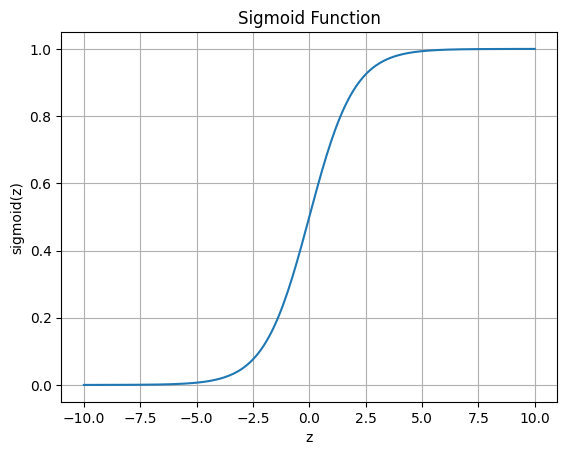

In [4]:
def sigmoid(z):
    z = np.clip(z, -500, 500)  # prevent overflow
    return 1 / (1 + np.exp(-z))

def predict_proba(X, w):
    return sigmoid(X.dot(w))

# Quick plot of sigmoid
z_vals = np.linspace(-10, 10, 200)
plt.plot(z_vals, sigmoid(z_vals))
plt.title("Sigmoid Function")
plt.xlabel("z")
plt.ylabel("sigmoid(z)")
plt.grid(True)
plt.savefig("sigmoid.png", dpi=300)
plt.show()


In [5]:
def compute_loss_and_grad(X, y, w):
    n = X.shape[0]
    p = predict_proba(X, w)
    eps = 1e-9
    p = np.clip(p, eps, 1 - eps)
    
    # Cross-entropy loss
    loss = - (1/n) * np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    
    # Gradient
    grad = (1/n) * X.T.dot(p - y)
    return loss, grad


Step 0, Loss = 0.6931
Step 500, Loss = 0.4467
Step 1000, Loss = 0.4453
Step 1500, Loss = 0.4452
Step 2000, Loss = 0.4452
Step 2500, Loss = 0.4452


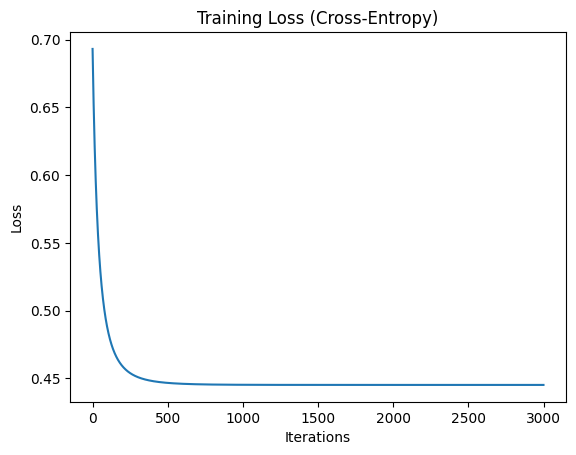

In [6]:
def train_logistic(X, y, lr=0.05, num_steps=3000, verbose=True):
    w = np.zeros(X.shape[1])
    losses = []
    
    for step in range(num_steps):
        loss, grad = compute_loss_and_grad(X, y, w)
        w -= lr * grad
        losses.append(loss)
        
        if verbose and step % 500 == 0:
            print(f"Step {step}, Loss = {loss:.4f}")
    return w, losses

# Train model
w, losses = train_logistic(X_train, y_train, lr=0.05, num_steps=3000)

plt.plot(losses)
plt.title("Training Loss (Cross-Entropy)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig("training_loss.png", dpi=300)
plt.show()


In [7]:
def predict(X, w, threshold=0.5):
    return (predict_proba(X, w) >= threshold).astype(int)

y_pred = predict(X_test, w)
accuracy = np.mean(y_pred == y_test)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.776536312849162


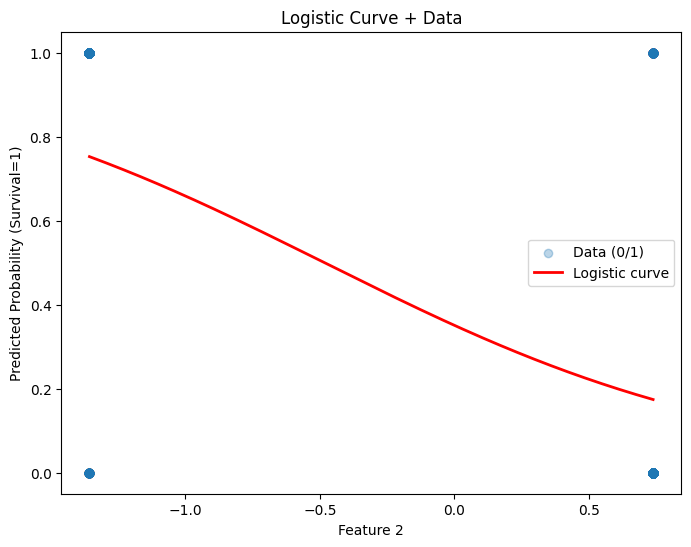

In [8]:
j = 2  # index of feature to visualize (e.g., Age after scaling)

x_j_all = X_bias[:, j]
x_min, x_max = np.min(x_j_all), np.max(x_j_all)
x_grid = np.linspace(x_min, x_max, 200)

logit_grid = w[0] + w[j] * x_grid
proba_grid = sigmoid(logit_grid)

plt.figure(figsize=(8,6))
plt.scatter(x_j_all, y, alpha=0.3, label="Data (0/1)")
plt.plot(x_grid, proba_grid, color="red", linewidth=2, label="Logistic curve")
plt.xlabel(f"Feature {j}")
plt.ylabel("Predicted Probability (Survival=1)")
plt.legend()
plt.title("Logistic Curve + Data")
plt.savefig("logistic_curve.png", dpi=300)
plt.show()


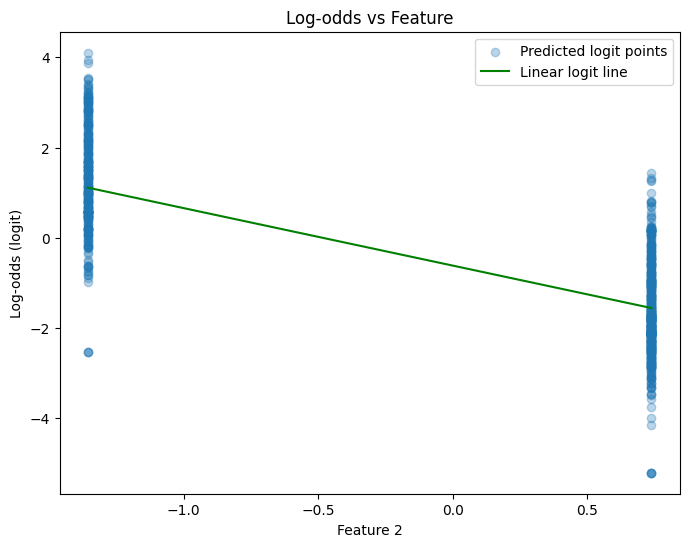

In [9]:
p_all = predict_proba(X_bias, w)
eps = 1e-9
p_all = np.clip(p_all, eps, 1 - eps)
logit_all = np.log(p_all / (1 - p_all))

plt.figure(figsize=(8,6))
plt.scatter(x_j_all, logit_all, alpha=0.3, label="Predicted logit points")
plt.plot(x_grid, logit_grid, color="green", label="Linear logit line")
plt.xlabel(f"Feature {j}")
plt.ylabel("Log-odds (logit)")
plt.legend()
plt.title("Log-odds vs Feature")
plt.savefig("log_odds.png", dpi=300)
plt.show()


Step 0, Loss = 0.6931
Step 500, Loss = 0.4476
Step 1000, Loss = 0.4463
Step 1500, Loss = 0.4462
Step 2000, Loss = 0.4462
Step 2500, Loss = 0.4462


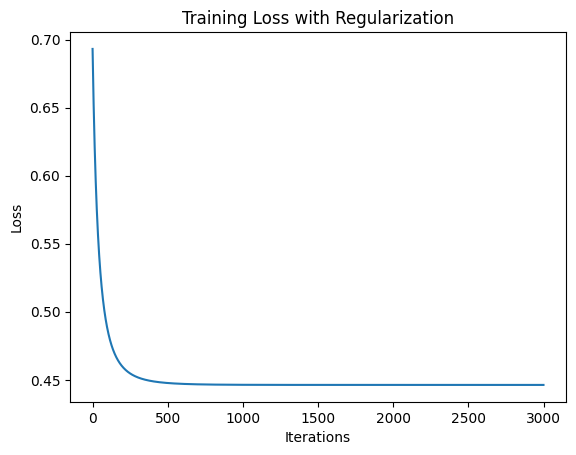

Test Accuracy with Regularization: 0.776536312849162


In [10]:
def compute_loss_and_grad_reg(X, y, w, reg_lambda=0.1):
    n = X.shape[0]
    p = predict_proba(X, w)
    eps = 1e-9
    p = np.clip(p, eps, 1 - eps)
    
    # Data loss
    loss = - (1/n) * np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    # Regularization loss (excluding bias)
    loss += (reg_lambda / (2*n)) * np.sum(w[1:]**2)
    
    grad = (1/n) * X.T.dot(p - y)
    grad[1:] += (reg_lambda / n) * w[1:]
    return loss, grad

def train_logistic_reg(X, y, lr=0.05, num_steps=3000, reg_lambda=0.5, verbose=True):
    w = np.zeros(X.shape[1])
    losses = []
    for step in range(num_steps):
        loss, grad = compute_loss_and_grad_reg(X, y, w, reg_lambda)
        w -= lr * grad
        losses.append(loss)
        if verbose and step % 500 == 0:
            print(f"Step {step}, Loss = {loss:.4f}")
    return w, losses

# Train with regularization
w_reg, losses_reg = train_logistic_reg(X_train, y_train, lr=0.05, num_steps=3000, reg_lambda=0.5)

plt.plot(losses_reg)
plt.title("Training Loss with Regularization")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig("regularized_loss.png", dpi=300)
plt.show()

y_pred_reg = predict(X_test, w_reg)
acc_reg = np.mean(y_pred_reg == y_test)
print("Test Accuracy with Regularization:", acc_reg)
